# Get Throughputs from Pandeia for WebbPSF

In [1]:
import sys
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import astropy.table
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Import pandeia and set paths

In [2]:
import pandeia, pandeia.engine, pandeia.engine.config
import pandeia.engine.jwst
from pandeia.engine.instrument_factory import InstrumentFactory

In [3]:
pandeia.engine.__path__

['/Users/mperrin/Dropbox (Personal)/Documents/software/git/pandeia/engine/pandeia/engine']

In [4]:
pandeia.engine.__version__

'2.1.dev0'

In [5]:
os.getenv('pandeia_refdata')

'/Users/mperrin/Dropbox/data/pandeia_data-2.0'

In [6]:
PANDEIA_VER = '2.0'

## Infrastructure helper functions

First define some helpful functions to use below. 

In [7]:
def get_pce(inst, normalize=False):
    wr = inst.get_wave_range()
    wave = np.linspace(wr['wmin']*0.95, wr['wmax']*1.05, num=500)
    pce = inst.get_total_eff(wave)    
    if normalize:
        pce /= pce.max()
    return (wave,pce)


def annotate_pce_plot(title="", xlim=(0.5,5.5), legend=True):
    plt.title(title)
    plt.ylabel("Photon Conversion Efficiency")
    plt.xlabel('Wavelength [$\mu$m]')
    plt.ylim(0,1)
    plt.xlim(*xlim)
    if legend:
        plt.legend(loc='upper right')
        
def plotlabelcolorfilt(wave,pce,filtname, color='blue', yoffset=0):
    
    meanwave = ((wave*pce).sum() / pce.sum())
    plt.fill_between(wave,0,pce, alpha=0.5, color=color)
    plt.plot(wave,pce, color=color, label=filtname.upper())
    plt.plot(wave,pce, color='black', alpha=0.5)
    # double print text to make it a bit darker since some of the rainbow colors are hard to read
    plt.text(meanwave, 0.75+yoffset, filtname.upper(), alpha=1, color='black', rotation=45)
    plt.text(meanwave, 0.75+yoffset, filtname.upper(), alpha=0.75, color=color, rotation=45)

def uppercase_si_name(name):
    # the SI name with case as typically used, and specifically as used with WebbPSF. 
    name = name.upper()
    if name=='NIRCAM': return 'NIRCam'
    elif name=='NIRSPEC': return 'NIRSpec'
    else: return name
    


In [8]:
def output_to_fits_table(wave,pce,inst, verbose=True, filtername=None):

    data = [wave*1e4,pce/pce.max()]  # convert wave to angstroms as expected by pysynphot

    (year, month, day, hour, minute, second, weekday, DOY, DST) =  time.gmtime()

    si_name = uppercase_si_name(inst.inst_name)
    if filtername is None:
        filtername = inst.instrument['filter']
    filtername = filtername.upper()

    t = astropy.table.Table(data, names=['WAVELENGTH', 'THROUGHPUT'])
    t['WAVELENGTH'].unit='angstrom'
    t.meta['WAVEUNIT']=('angstrom', 'Wavelength unit')
    t.meta['TELESCOP']=('JWST', 'James Webb Space Telescope')
    t.meta['INSTRUME']=(si_name, 'Name of instrument')
    t.meta['FILTER']=(filtername, 'Bandpass filter identifier')
    t.meta['SOURCE']=('JWST ETC / Pandeia / REDCAT', 'Derived from JWST ETC database')
    t.meta["SRC_DATE"] = ( "%4d-%02d-%02d" % (year, month, day), "Date of file generation from ETC")
    t.meta['SRC_VER'] = (PANDEIA_VER, "Version of Pandeia ETC and reference data")

    t.meta['NORMALIZ']=(True, 'Normalized to peak transmission=1')

    t.meta['HISTORY'] = ['Normalized relative spectral response file for WebbPSF', '',
                         'Based on information extracted from the ',
                         'JWST Exposure Time Calculator (ETC) system',
                         '(Pandeia software database, using reference files',
                         'managed by ReDCaT, the Reference Data for ',
                         'Calibration and Tools group at STScI)', '',
                         'Pandeia engine and reference data available from',
                         'https://pypi.org/project/pandeia.engine/','',
                         'This file created by: "webbpsf/dev_tools/',
                         '  Normalized Throughputs from Pandeia.ipynb"',
                         '']

    if not os.path.isdir('outputs'):
        os.mkdir('outputs')
    
    if not os.path.isdir(os.path.join('outputs',si_name)):
        os.mkdir(os.path.join('outputs',si_name))
    
    outname = os.path.join('outputs',si_name,"{}_throughput.fits".format(filtername))
    t.write(outname, overwrite=True)
    if verbose:
        print("==>> "+outname)
    return outname



## Obtain & display Photon Conversion Efficiency for a single filter

NIRISS is used as simple imager test case here, since NIRCam has the SW/LW complication. 

==>> outputs/NIRISS/F200W_throughput.fits


'outputs/NIRISS/F200W_throughput.fits'

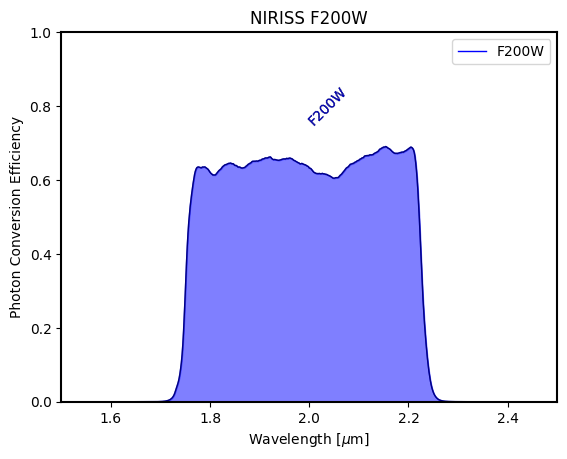

In [9]:
inst = pandeia.engine.jwst.NIRISS(mode='imaging')
wave,pce=get_pce(inst)

plotlabelcolorfilt(wave,pce, inst.instrument['filter'])

annotate_pce_plot(title=("{} {}".format(inst.instrument['instrument'], 
                                        inst.instrument['filter'])).upper(), 
                  xlim=(1.5, 2.5))
output_to_fits_table(wave,pce,inst)

## Iterate over all filters for an instrument

### Instruments that work currently: NIRISS, MIRI, NIRCam 

#### NIRISS

==>> outputs/NIRISS/F090W_throughput.fits
==>> outputs/NIRISS/F115W_throughput.fits
==>> outputs/NIRISS/F140M_throughput.fits
==>> outputs/NIRISS/F150W_throughput.fits
==>> outputs/NIRISS/F158M_throughput.fits
==>> outputs/NIRISS/F200W_throughput.fits
==>> outputs/NIRISS/F277W_throughput.fits
==>> outputs/NIRISS/F356W_throughput.fits
==>> outputs/NIRISS/F380M_throughput.fits
==>> outputs/NIRISS/F430M_throughput.fits
==>> outputs/NIRISS/F444W_throughput.fits
==>> outputs/NIRISS/F480M_throughput.fits


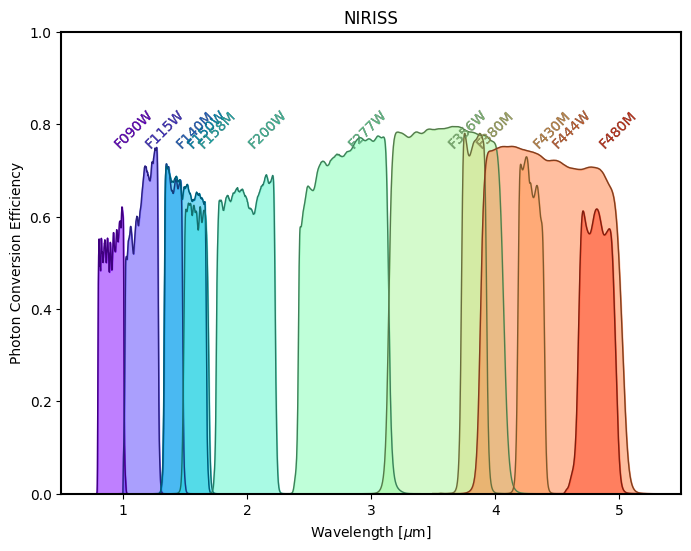

In [10]:
inst_defaults = pandeia.engine.jwst.NIRISS(mode='imaging')
config = inst_defaults.as_dict()  # get default config
colorseq=iter(matplotlib.cm.rainbow(np.linspace(0,1,len(inst_defaults.filters))))


plt.figure(figsize=(8,6))
for filtname in inst_defaults.filters:
    #print(filtname)
    if filtname=='clear':
        continue
    
    config['instrument']['filter']=filtname
    inst = InstrumentFactory(config=config)

    wave,pce=get_pce(inst)
    plotlabelcolorfilt(wave,pce,filtname, color=next(colorseq))
    output_to_fits_table(wave,pce,inst)

annotate_pce_plot(title=inst.inst_name.upper(), legend=False)

#### MIRI

==>> outputs/MIRI/F1065C_throughput.fits
==>> outputs/MIRI/F1140C_throughput.fits
==>> outputs/MIRI/F1550C_throughput.fits
==>> outputs/MIRI/F2300C_throughput.fits
==>> outputs/MIRI/F560W_throughput.fits
==>> outputs/MIRI/F770W_throughput.fits
==>> outputs/MIRI/F1000W_throughput.fits
==>> outputs/MIRI/F1130W_throughput.fits
==>> outputs/MIRI/F1280W_throughput.fits
==>> outputs/MIRI/F1500W_throughput.fits
==>> outputs/MIRI/F1800W_throughput.fits
==>> outputs/MIRI/F2100W_throughput.fits
==>> outputs/MIRI/F2550W_throughput.fits
==>> outputs/MIRI/FND_throughput.fits


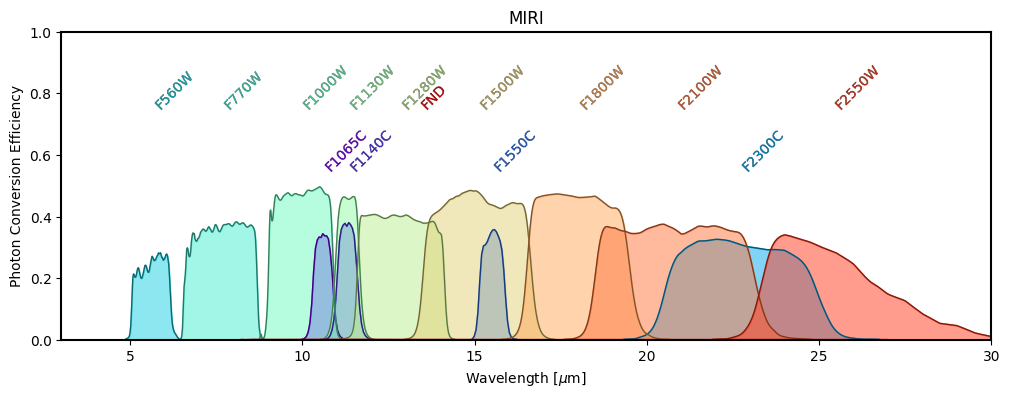

In [11]:
inst_defaults = pandeia.engine.jwst.MIRI(mode='imaging')
config = inst_defaults.as_dict()  # get default config

plt.figure(figsize=(12,4))
colorseq=iter(matplotlib.cm.rainbow(np.linspace(0,1,len(inst_defaults.filters))))


for filtname in inst_defaults.filters:

    config['instrument']['filter']=filtname
    inst = pandeia.engine.jwst.MIRI(mode='imaging', config=config)

    wave,pce=get_pce(inst)
    plotlabelcolorfilt(wave,pce,filtname, color=next(colorseq), yoffset=-0.2 if 'c' in filtname else 0.0)
    output_to_fits_table(wave,pce,inst)

annotate_pce_plot(title=uppercase_si_name(inst.inst_name), xlim=(3,30), legend=False)

#### NIRCam

wide ['f070w', 'f090w', 'f115w', 'f150w', 'f150w2', 'f200w', 'f277w', 'f322w2', 'f356w', 'f444w']
==>> outputs/NIRCam/F070W_throughput.fits
==>> outputs/NIRCam/F090W_throughput.fits
==>> outputs/NIRCam/F115W_throughput.fits
==>> outputs/NIRCam/F150W_throughput.fits
==>> outputs/NIRCam/F150W2_throughput.fits
==>> outputs/NIRCam/F200W_throughput.fits
==>> outputs/NIRCam/F277W_throughput.fits
==>> outputs/NIRCam/F322W2_throughput.fits
==>> outputs/NIRCam/F356W_throughput.fits
==>> outputs/NIRCam/F444W_throughput.fits
medium ['f140m', 'f162m', 'f182m', 'f210m', 'f250m', 'f300m', 'f335m', 'f360m', 'f410m', 'f430m', 'f460m', 'f480m']
==>> outputs/NIRCam/F140M_throughput.fits
==>> outputs/NIRCam/F162M_throughput.fits
==>> outputs/NIRCam/F182M_throughput.fits
==>> outputs/NIRCam/F210M_throughput.fits
==>> outputs/NIRCam/F250M_throughput.fits
==>> outputs/NIRCam/F300M_throughput.fits
==>> outputs/NIRCam/F335M_throughput.fits
==>> outputs/NIRCam/F360M_throughput.fits
==>> outputs/NIRCam/F410M_th

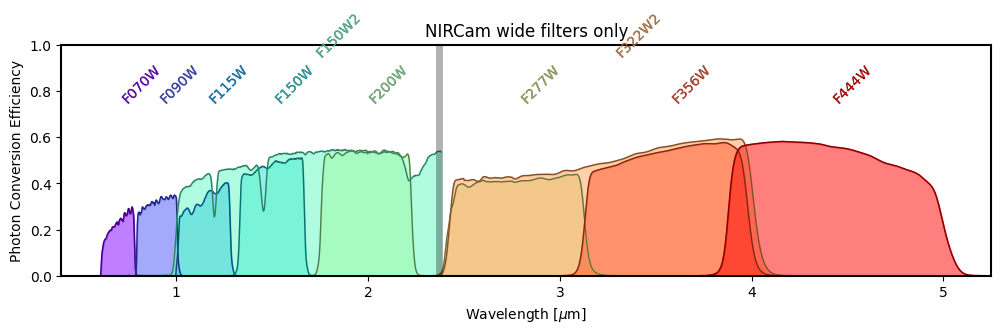

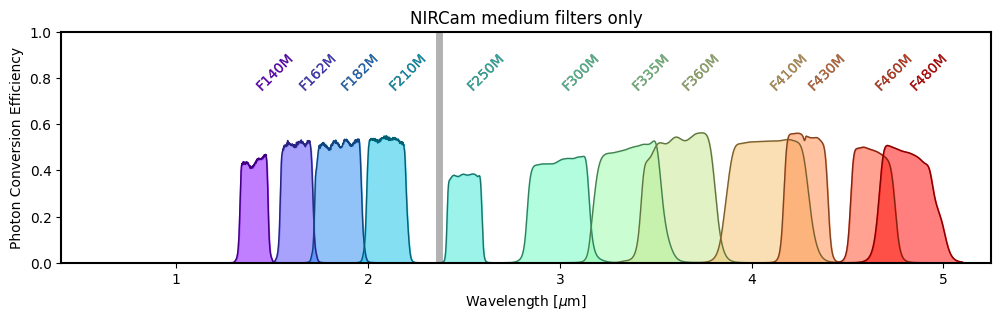

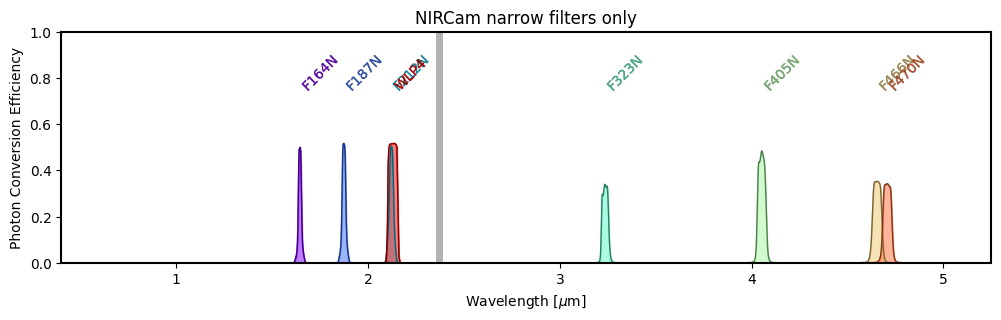

In [12]:
# Determine NIRCam filters. 
# COnveniently the filters attribute has all the SW and LW filters together, regardless of which channel you selet. 
inst_defaults = pandeia.engine.jwst.NIRCam(mode='lw_imaging')
filters = inst_defaults.filters
filters = [f for f in filters if not f.endswith('_nd')]


config_lw = pandeia.engine.jwst.NIRCam(mode='lw_imaging').as_dict() 
config_sw = pandeia.engine.jwst.NIRCam(mode='sw_imaging').as_dict() 



for width in ['wide','medium','narrow']:
    plt.figure(figsize=(12,3))

    
    filters_thiswide = [f for f in filters if (len(f)>4 and f[4]== width[0])]
    if width=='narrow':
        filters_thiswide.append('wlp4')
    print(width, filters_thiswide)
    
    nfilters = len(filters_thiswide)
    colorseq=iter(matplotlib.cm.rainbow(np.linspace(0,1,nfilters)))

    for filtname in filters_thiswide:

        if (width[0] not in filtname) and (filtname!='wlp4'): continue
#        if "_nd" in filtname: continue

        if (filtname=='wlp4') or (int(filtname[1:3]) < 25):
            mode = 'sw_imaging' 
            config = config_sw
        else:
            mode = 'lw_imaging'
            config = config_lw
        config['instrument']['filter']=filtname

        #if filtname=='f322w': filtname='f322w2' # work around limitation in current config setup

        inst = pandeia.engine.jwst.NIRCam(mode=mode, config=config)

        wr = inst.get_wave_range()
        wave = np.linspace(wr['wmin'], wr['wmax'], num=500)
        pce = inst.get_total_eff(wave)

        plotlabelcolorfilt(wave,pce,filtname, color=next(colorseq), 
                           yoffset =0.2 if filtname.endswith('w2') else 0)
        output_to_fits_table(wave,pce,inst, filtername=filtname)

    annotate_pce_plot(title=uppercase_si_name(inst.inst_name)+" {} filters only".format(width), 
                      xlim=(0.4, 5.25), legend=False)
    #plt.ylim(0,0.85)  #match NIRCam pocket guide PDF
    plt.ylim(0, 1.0)
    plt.axvline(2.37, ls="-", color='black', alpha=0.3, linewidth=5) 
 

### Instrument that needs some special handling - NIRSpec

Tim P says in Feb 2016: 

"nirspec imaging hasn’t been implemented yet.  there are stubs for it in the configuration file, but not all of the necessary configuration data is there. "

In [13]:
import pandeia.engine.calc_utils
nrs_config = pandeia.engine.calc_utils.build_default_calc('jwst', 'nirspec', 'imaging')['configuration']

In [14]:
# Set up config for imaging / TA mode
nrs_config['instrument']['disperser']=None
nrs_config['instrument']['aperture']='shutter'
nrs_config

{'detector': {'nexp': 1,
  'ngroup': 10,
  'nint': 1,
  'readout_pattern': 'nrs',
  'subarray': 'full'},
 'dynamic_scene': False,
 'instrument': {'aperture': 'shutter',
  'disperser': None,
  'filter': 'f100lp',
  'instrument': 'nirspec',
  'mode': 'ifu'},
 'max_filter_leak': 0.05}

==>> outputs/NIRSpec/F110W_throughput.fits
==>> outputs/NIRSpec/F140X_throughput.fits
==>> outputs/NIRSpec/CLEAR_throughput.fits


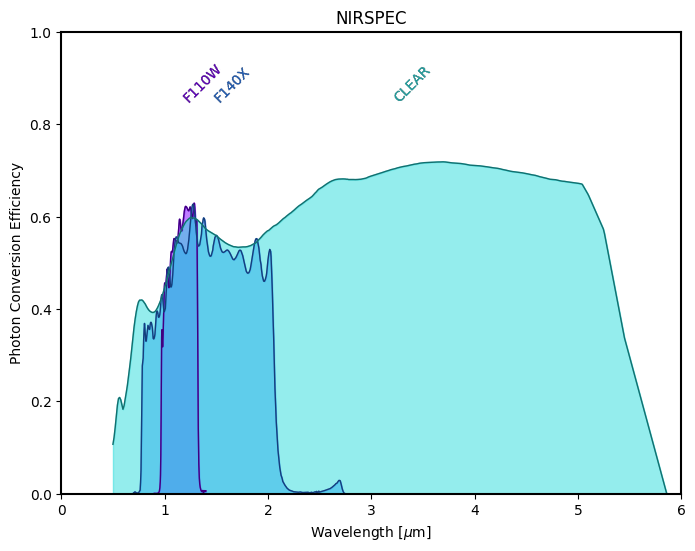

In [15]:
inst_defaults = pandeia.engine.jwst.NIRSpec(config=nrs_config, mode='target_acq')
nrs_config = pandeia.engine.calc_utils.build_default_calc('jwst', 'nirspec', 'imaging')['configuration']
# Set up config for imaging / TA mode
nrs_config['instrument']['disperser']=None
nrs_config['instrument']['aperture']='shutter'

#inst_defaults = pandeia.engine.jwst.NIRSpec(mode='ta')
#config = inst_defaults.as_dict()  # get default config

plt.figure(figsize=(8,6))
colorseq=iter(matplotlib.cm.rainbow(np.linspace(0,1,len(inst_defaults.filters))))

#For NIRSpec, we only support a handful of filters, the same as what the ETC supports for TA mode.
# If you're using one of the LP filters with a grism then you presumably will do a bunch of monochromatic calculations.

#for filtname in inst_defaults.filters:
for filtname in ['f110w', 'f140x', 'clear']:

    nrs_config['instrument']['filter']=filtname
    inst = pandeia.engine.jwst.NIRSpec(mode='target_acq', config=nrs_config)


    wr = inst.get_wave_range()
    wave = np.linspace(wr['wmin'], wr['wmax'], num=500)
    pce = inst.get_total_eff(wave)

    plotlabelcolorfilt(wave,pce,filtname, color=next(colorseq), 
                       yoffset =0.1)
    output_to_fits_table(wave,pce,inst, filtername=filtname)

    
       
#    wave,pce=get_pce(inst)
#    color=next(colorseq)
#plt.fill_between(wave,0, pce, color=color, alpha=0.35)
#    plt.plot(wave,pce,color=color, label=filtname.upper())


annotate_pce_plot(title=inst.inst_name.upper(), xlim=(0,6), legend=False)

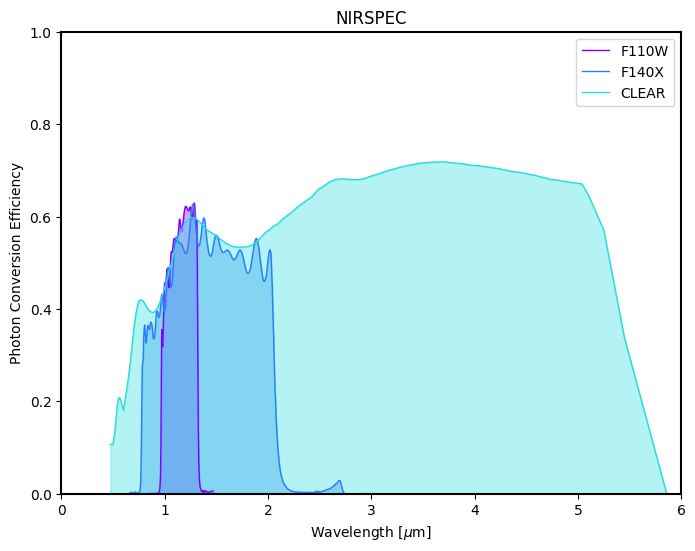

In [16]:
inst_defaults = pandeia.engine.jwst.NIRSpec(config=nrs_config, mode='target_acq')
nrs_config = pandeia.engine.calc_utils.build_default_calc('jwst', 'nirspec', 'imaging')['configuration']
# Set up config for imaging / TA mode
nrs_config['instrument']['disperser']=None
nrs_config['instrument']['aperture']='shutter'

#inst_defaults = pandeia.engine.jwst.NIRSpec(mode='ta')
#config = inst_defaults.as_dict()  # get default config

plt.figure(figsize=(8,6))
colorseq=iter(matplotlib.cm.rainbow(np.linspace(0,1,len(inst_defaults.filters))))

#For NIRSpec, we only support a handful of filters, the same as what the ETC supports for TA mode.
# If you're using one of the LP filters with a grism then you presumably will do a bunch of monochromatic calculations.

#for filtname in inst_defaults.filters:
for filtname in ['f110w', 'f140x', 'clear']:

    nrs_config['instrument']['filter']=filtname
    inst = pandeia.engine.jwst.NIRSpec(mode='target_acq', config=nrs_config)

    wave,pce=get_pce(inst)
    color=next(colorseq)
    plt.fill_between(wave,0, pce, color=color, alpha=0.35)
    plt.plot(wave,pce,color=color, label=filtname.upper())


annotate_pce_plot(title=inst.inst_name.upper(), xlim=(0,6))

# FGS



In [17]:
# FGS is not in Pandeia - get the spectral response from someone on FGS team directly.